In [25]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

import numpy as np
#from ipynb.fs.full.AppProcessing import *
from itertools import zip_longest
import itertools as itertools

from scipy import signal
from scipy.fftpack import fftshift
from scipy import fftpack
import datetime

print("Huhu")

Huhu


In [3]:
def prepareCsvForPkgId(input_file):
    """
    Input:
        file (string): Is a csv produced by the app after 11.09.2020 containing info on the package ID. 
    Returns:
        file (dataframe): A kind of cleaned dataframe with an evenly space timestamp as index 
        ids (list): A list with the package ids as ints
        filename (string): The name of the experiment (if the name given from the app, inclusing the timestamp) was used)
    """
    file = pd.read_csv(input_file)
    file = file.iloc[1:]
    file.columns = file.iloc[0]

    file = file[1:].apply(pd.to_numeric, errors='ignore')

    # to evenly set the timestamps 
    length = len(file.index) # length of dataframe
    stop = length*4 # stop point 
    index_evenly = np.linspace(0, stop, num = length, endpoint = False) # to adapt timestamp  
    
    # transform index to datetime 
    
    file.loc[:,"Time"] = index_evenly #set the time as index, relevant for later plotting
    file["Time"] = pd.to_datetime(file["Time"],unit="ms") #for better frequency analysis
    
    ids= file.index.tolist() # these are all the package ids (as strings because, yes pandas of course we want that as strings, strings are soooo useful..Not)
    ids = [int(one_id) for one_id in ids] # now they are ints


    file.set_index('Time', inplace=True)
    # 
    filename = input_file[20:-4]
    return file, ids, filename # no idea why, but the name of the index still includes "Pkg ID", the id not actually the index. Time is .. 

def plotTraceApp(df, channelname = ["Ch-1","Ch-2","Ch-3","Ch-4","Ch-5","Ch-6"], fro = 0, to = 1000, sec=False, title = "Experiment", save = False, saveas = "Experiment"):
    """
    Plots the trace from individual Traumschreiber channels. 
    --------------
    Parameter:
    df: a cleaned up dataframe containing the app output
    channelname: the channelname to be displayed (default all, select subset if required) 
    fro (int): Starting point to plot the trace (in msec). If that msec does not correspond to a measurement, the closest one is used 
    to (int): End of the plot in msec. If that msec does not correspond to a measurement, the closest one is used instead.
    sec (boolean): If index is in seconds (specified in tidyTSAppOutput), the axis label is changed 
    title: Title of the plot
    save (boolean): True if plot shall be saved (in working directory) as png
    saveas (string): Name of the saved file
    """
    
    try: #find the nearest timestamp (only possible when index is unique)
        start = df.index.get_loc(fro, method = "nearest")
        stop = df.index.get_loc(to, method = "nearest")
        
    except: #if the data is not evenly spaced, there might be dublicated timestamps. Hack-around required
        # assuming the start/end point is given in msec (specified in function description). 
        # In average there should be a new measurement every 4 msec (sampling rate 250 Hz).
        # We calculate the indices that roughly correspond to the desired starting and stopping msecs instead
        samplingInterval = 4 
        start = int(fro/samplingInterval)
        stop = int(to/samplingInterval) 
    toPlot = df.iloc[start:stop] # cut only relevant part of dataframe for plotting
    
    #to do: count # channels to be plotted and automatically adapt plot size
    
    toPlot.plot(y = channelname, grid = True, title = title, sharex = False, marker='o', figsize = (30,6), subplots = True) #removed figsize

    if sec:
        plt.xlabel('Seconds')
    else:
        plt.xlabel("msec")
    plt.ylabel("mVolt")
     
    if save:    
        plt.savefig(saveas+'.png') # saves as .png at the moment as was better for displaying/discussing in slack
    plt.show()


In [4]:
freq_change = prepareCsvForPkgId("16-09-2020_15-01-51_5to50.csv")[0]
freq_change
around50 = prepareCsvForPkgId("18-09-2020_15-13-33_expno1.csv")[0]
#plotTraceApp(freq_change, ["Ch-1"], fro = 0, to 1000)

C:\Users\lkrie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3248: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


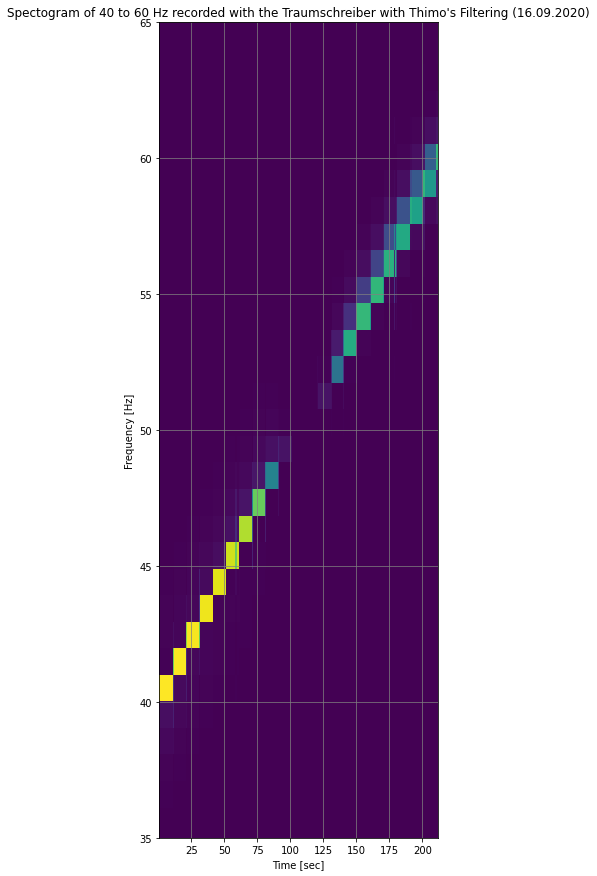

In [84]:
x = around50.iloc[:]["Ch-1"]#.to_list()
fs = 250

f, t, Sxx = signal.spectrogram(x, fs) #scaling = "spectrum")#, ‘spectrum’ )
# [‘psd’, ‘complex’, ‘magnitude’, ‘angle’, ‘phase’]


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.pcolormesh(t, f, Sxx)#, shading='gouraud')



# And a corresponding grid
#ax.grid(which='both')
spacing = 5 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)
#ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_minor_locator(minorLocator)
ax.grid(b = True, which = "both", color = "grey", alpha = 0.9)


plt.ylim((35, 65)) 
plt.rcParams["figure.figsize"] = (5,15)
#plt.grid(b = True, which = "both", color = "white")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectogram of 40 to 60 Hz recorded with the Traumschreiber with Thimo's Filtering (16.09.2020)")
plt.savefig("FrequencyChanges40to60Hz.png")
plt.show()

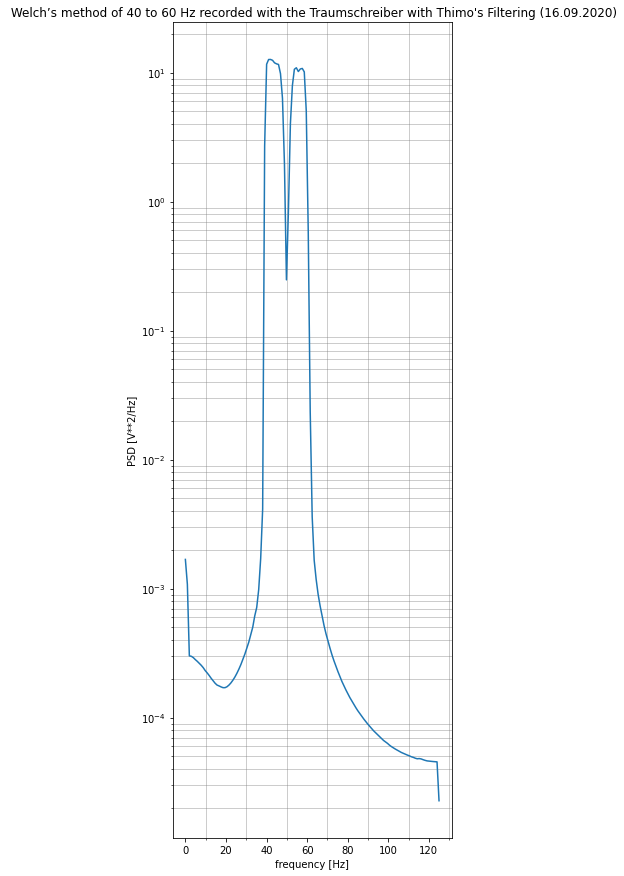

In [87]:


f, Pxx_den = signal.welch(x, fs)#, nperseg=1024)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])


spacing = 10 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)
ax1.xaxis.set_minor_locator(minorLocator)

ax1.grid(b = True, which = "minor", color = "grey", alpha = 0.5)
#Spacing between each line
#intervals = 2 #float(sys.argv[1])



# Add the grid
#ax1.grid(which='major', axis='both', linestyle='-')
#ax1.grid(which = 'minor')
plt.title(" Welch’s method of 40 to 60 Hz recorded with the Traumschreiber with Thimo's Filtering (16.09.2020)")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.savefig("Welch40to60Hz.png")
plt.show()

C:\Users\lkrie\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


(-5.0, 110.0)

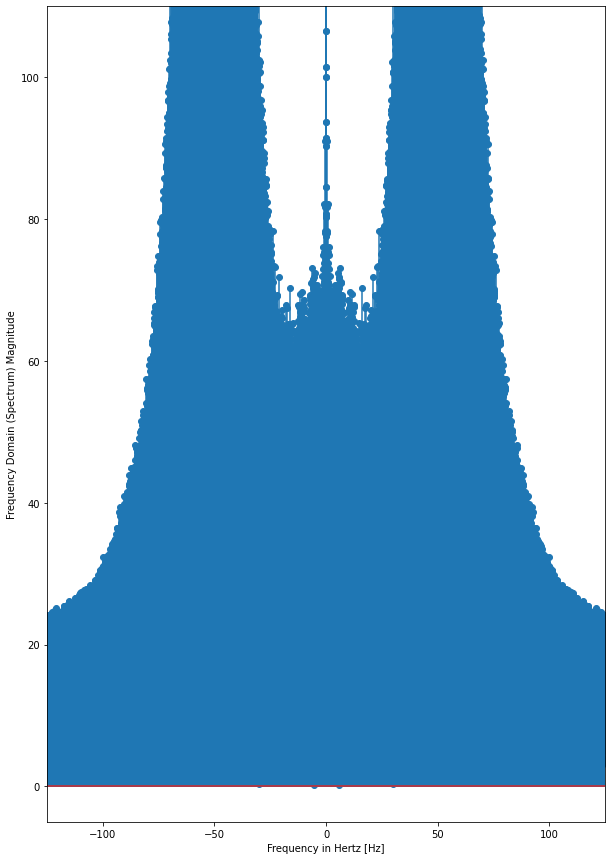

In [35]:
X = fftpack.fft(x)
f_s = 250
freqs = fftpack.fftfreq(len(x)) * f_s

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)
ax.set_ylim(-5, 110)

ValueError: x and y must have same first dimension, but have shapes (237,) and (53126,)

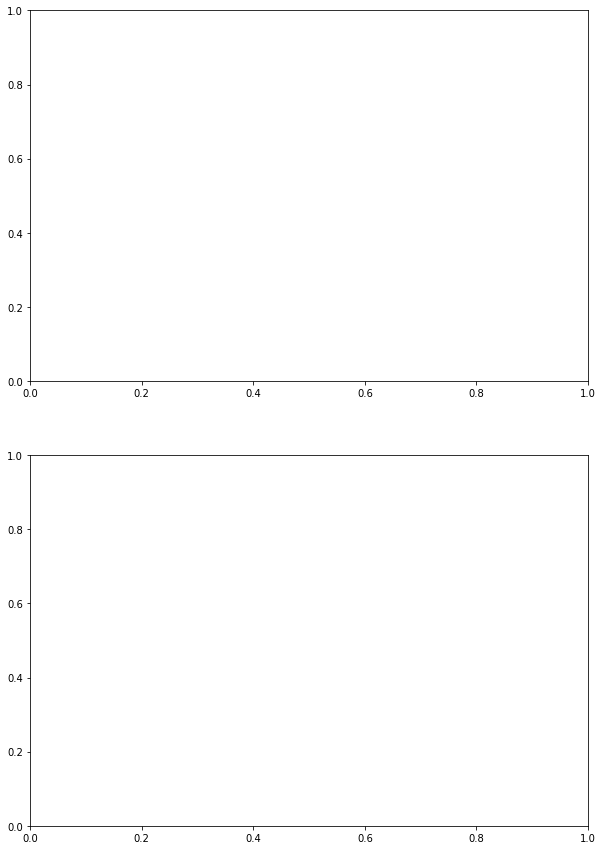

In [36]:
#x = s1 + s2 + nse  # the signal
NFFT = 1024  # the length of the windowing segments
Fs = 250  # the sampling frequency

#t = np.arange(0.0, 20.0, dt)

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(t, x)
Pxx, freqs, bins, im = ax2.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=900)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
plt.show()